# **IncidentSense - AI Powered Disaster Intelligence in BigQuery**

***A SQL-first disaster intelligence system that unifies hazard data, enriches it with context, & generates summary and action list in minutes.***

When disasters strike, emergency managers and humanitarian analysts must act quickly. Today, they spend hours manually collecting data from NOAA, GDELT, OpenAQ, and other fragmented sources, then summarizing key details before decisions can be made. This lag in situational awareness can delay response and cost lives. My solution leverages BigQuery AI to unify hazard feeds, enrich them with population and infrastructure context, and automatically generate human-ready briefs and action plan — all directly in SQL.

##**Architecture**

1. Ingest & Normalize: Public datasets (NOAA storms, IBTrACS hurricanes, USGS earthquakes, GDELT, OpenAQ, EPA air quality).
2. Incident Enrichment: Join population estimates + Overture Maps roads.
3. Semantic Layer: ML.GENERATE_EMBEDDING - VECTOR_SEARCH for similar events.
4. Generative Summaries: ML.GENERATE_TEXT produces briefs with severity, exposure, AQI shifts, and recommended actions.
5. Give out an action plan




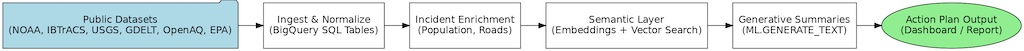

# -- ============================================

# -- **0) Setup: create working dataset**

# -- ============================================

In [ ]:
%%bigquery results
CREATE SCHEMA IF NOT EXISTS `bqai_disaster`;

# -- ==============================================================

# -- **1) Ingest raw incidents from public datasets**

# -- NOAA Storms, IBTrACS Hurricanes, USGS Earthquakes, OpenAQ AirQuality

# -- ==============================================================

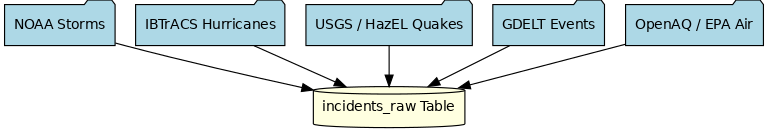

**-- (A) Create a GCS bucket**

In [ ]:
import random

# Generate a random integer between 1 and 100000 (inclusive)
random_integer = random.randint(1, 100000)
bucket_name = climate_stewardship_ibtracs_data_{str(random_integer)}
!gsutil mb gs://bucket_name

Creating gs://climate_stewardship_ibtracs_data_86933/...


**-- (B) GET IBTrACS data for hurricanes and cyclones**

In [ ]:
from google.cloud import storage, bigquery
import requests

# ---------- Inputs ----------
# bucket_name = "climate_stewardship_ibtracs_data"
destination_blob_name = "climate_stewardship_ibtracs.csv"
url_to_upload = (
    "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-"
    "stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv"
)
dataset_id = "bqai_disaster"
table_name = "climate_stewardship_ibtracs"
# ----------------------------

# Upload the file to GCS
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

response = requests.get(url_to_upload, stream=True)
response.raise_for_status()
blob.upload_from_string(response.content)
gcs_uri = f"gs://{bucket_name}/{destination_blob_name}"
print(f"File from {url_to_upload} uploaded to {gcs_uri}")

# Load into BigQuery
bq_client = bigquery.Client()

# Use your default project if not specified; build fully-qualified table ID
full_table_id = f"{bq_client.project}.{dataset_id}.{table_name}"

# Ensure dataset exists (no-op if it already does)
try:
    bq_client.get_dataset(dataset_id)
except Exception:
    bq_client.create_dataset(dataset_id)
    print(f"Created dataset: {dataset_id}")

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    autodetect=True,              # Let BQ infer schema
    skip_leading_rows=1,          # CSV has a header row
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,  # overwrite each run
    allow_quoted_newlines=True,   # safer for complex CSVs
)

load_job = bq_client.load_table_from_uri(
    gcs_uri,
    full_table_id,
    job_config=job_config,
)
print(f"Starting BigQuery load job {load_job.job_id} → {full_table_id} ...")
load_job.result()  # Wait for the job to complete

table = bq_client.get_table(full_table_id)
print(
    f"Loaded {table.num_rows} rows and {len(table.schema)} columns into {full_table_id}."
)


File from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv uploaded to gs://climate_stewardship_ibtracs_data/climate_stewardship_ibtracs.csv
Starting BigQuery load job e9ed6b21-6052-4244-9f83-55c3c89f8658 → incidentsense.bqai_disaster.climate_stewardship_ibtracs ...
Loaded 720055 rows and 174 columns into incidentsense.bqai_disaster.climate_stewardship_ibtracs.


**-- (C) Get Hurricanes data from NOAA**

In [ ]:
import time
import requests
import pandas as pd
from google.cloud import bigquery

BASE_URL = "https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes"

# Your filters from the SQL WHERE
COMMON_PARAMS = {
    "minLatitude": -90,
    "maxLatitude": 90,
    "minLongitude": -180,
    "maxLongitude": 180,
}

START_YEAR = 1901   # > 1900
END_YEAR   = 2025   # <= 2025
REQUEST_TIMEOUT = 60
SLEEP_BETWEEN_CALLS = 0.2  # be gentle to the API

def fetch_year(year: int):
    """Fetch one calendar year's records."""
    params = {
        **COMMON_PARAMS,
        "minYear": year,
        "maxYear": year,
    }
    r = requests.get(BASE_URL, params=params, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    data = r.json()
    # HazEL returns either {"items":[...]} or a bare list
    items = data.get("items", data) if isinstance(data, dict) else data
    return items or []

# ---- pull all years, with basic retry/backoff ----
all_rows = []
for yr in range(START_YEAR, END_YEAR + 1):
    for attempt in range(3):
        try:
            rows = fetch_year(yr)
            all_rows.extend(rows)
            break
        except requests.HTTPError as e:
            # crude backoff for transient 5xx/429s
            if attempt < 2 and (500 <= e.response.status_code < 600 or e.response.status_code == 429):
                time.sleep(1.5 * (attempt + 1))
                continue
            raise
        finally:
            time.sleep(SLEEP_BETWEEN_CALLS)

# --- Step 2: Convert to Pandas DataFrame ---
# ---- to DataFrame + de-dupe on 'id' ----
df = pd.DataFrame(all_rows)

if df.empty:
    raise SystemExit("No rows returned. Check filters or API availability.")

if "id" in df.columns:
    df.drop_duplicates(subset=["id"], inplace=True)


def coerce_int64_nullable(s: pd.Series) -> pd.Series:
    # If series holds non-scalars (lists/dicts), don't try to cast
    if s.apply(lambda x: isinstance(x, (list, dict))).any():
        return s  # leave as-is

    # Replace obvious empties with NA
    s = s.replace(r'^\s*$', pd.NA, regex=True)

    # Work as string, extract first integer if present (handles "1900?", "  1975 ", etc.)
    extracted = (
        s.astype(str)
         .str.strip()
         .str.extract(r'(-?\d+)', expand=False)  # first integer substring
    )

    # Convert to numeric (will be float if not cast), then to nullable Int64
    out = pd.to_numeric(extracted, errors="coerce").astype("Int64")
    return out

def coerce_float_nullable(s: pd.Series) -> pd.Series:
    # Skip non-scalars
    if s.apply(lambda x: isinstance(x, (list, dict))).any():
        return s
    s = s.replace(r'^\s*$', pd.NA, regex=True)
    # Extract a float-like number (handles "-123.45", "12,345.6" → "12345.6")
    cleaned = (
        s.astype(str)
         .str.strip()
         .str.replace(",", "", regex=False)
         .str.extract(r'(-?\d+(?:\.\d+)?)', expand=False)
    )
    return pd.to_numeric(cleaned, errors="coerce")

# ---- apply robust typing ----
if not df.empty:
    int_cols = [c for c in ["year","month","day","hour","minute","second"] if c in df.columns]
    float_cols = [c for c in ["latitude","longitude","eqMagnitude","depth"] if c in df.columns]

    for c in int_cols:
        df[c] = coerce_int64_nullable(df[c])

    for c in float_cols:
        df[c] = coerce_float_nullable(df[c])

    # Optional: show which columns still couldn't be cast (useful for debugging)
    # print(df[int_cols + float_cols].dtypes)



# ---- load to BigQuery ----
client = bigquery.Client()
table_id = "bqai_disaster.earthquakes_noaa_hazel"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
    autodetect=True,  # let BQ infer the schema
)

load_job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
load_job.result()

print(f"Loaded {len(df)} rows into {table_id}")

Loaded 4006 rows into bqai_disaster.earthquakes_noaa_hazel


**-- (D) Combine all the disasters data together**

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incidents_raw` AS

-- 1) NOAA Storms
SELECT
  'storm' AS hazard_type,
  event_id,
  event_begin_time AS start_time,
  event_end_time   AS end_time,
  ST_GEOGPOINT(event_longitude, event_latitude) AS geom,
  event_type,
  CAST(magnitude AS FLOAT64) AS severity,
  COALESCE(deaths_direct,0)+COALESCE(deaths_indirect,0) AS fatalities,
  COALESCE(injuries_direct,0)+COALESCE(injuries_indirect,0) AS injuries,
  COALESCE(damage_property,0)+COALESCE(damage_crops,0) AS damage_usd,
  "NOAA Storms" AS source
FROM `bigquery-public-data.noaa_historic_severe_storms.storms_*`

UNION ALL

-- 2) IBTrACS tropical cyclones
SELECT
  'hurricane' AS hazard_type,
  SID AS event_id,
  SAFE_CAST(ISO_TIME AS DATETIME) AS start_time,
  SAFE_CAST(ISO_TIME AS DATETIME) AS end_time,
  ST_GEOGPOINT(SAFE_CAST(LON AS FLOAT64), SAFE_CAST(LAT AS FLOAT64)) AS geom,
  "tropical cyclone" AS event_type,
  SAFE_CAST(WMO_WIND AS FLOAT64) AS severity,
  NULL AS fatalities,
  NULL AS injuries,
  NULL AS damage_usd,
  "IBTrACS v04r01" AS source
FROM `bqai_disaster.climate_stewardship_ibtracs`
WHERE SAFE_CAST(ISO_TIME AS DATETIME) IS NOT NULL
  AND EXTRACT(YEAR FROM SAFE_CAST(ISO_TIME AS DATETIME)) BETWEEN 1901 AND 2025

UNION ALL

-- 3) HazEL Earthquakes
(
  WITH src AS (
  SELECT
    CAST(id AS STRING) AS id,
    SAFE_CAST(year AS INT64)    AS y,
    SAFE_CAST(month AS INT64)   AS m,
    SAFE_CAST(day AS INT64)     AS d,
    SAFE_CAST(hour AS INT64)    AS hh,
    SAFE_CAST(minute AS INT64)  AS mm,
    COALESCE(SAFE_CAST(second AS FLOAT64), SAFE_CAST(second AS INT64)) AS ss,
    SAFE_CAST(latitude AS FLOAT64)  AS lat,
    SAFE_CAST(longitude AS FLOAT64) AS lon,
    SAFE_CAST(eqMagnitude AS FLOAT64) AS severity
  FROM `bqai_disaster.earthquakes_noaa_hazel`
)
SELECT
  'earthquake' AS hazard_type,
  id           AS event_id,
  CASE WHEN y>=1 AND m BETWEEN 1 AND 12 AND d BETWEEN 1 AND 31
         AND hh BETWEEN 0 AND 23 AND mm BETWEEN 0 AND 59
         AND COALESCE(ss,0) BETWEEN 0 AND 59.9999
       THEN DATETIME(y,m,d,hh,mm,CAST(FLOOR(COALESCE(ss,0)) AS INT64)) END AS start_time,
  CASE WHEN y>=1 AND m BETWEEN 1 AND 12 AND d BETWEEN 1 AND 31
         AND hh BETWEEN 0 AND 23 AND mm BETWEEN 0 AND 59
         AND COALESCE(ss,0) BETWEEN 0 AND 59.9999
       THEN DATETIME(y,m,d,hh,mm,CAST(FLOOR(COALESCE(ss,0)) AS INT64)) END AS end_time,
  CASE WHEN lat BETWEEN -90 AND 90 AND lon BETWEEN -180 AND 180
       THEN ST_GEOGPOINT(lon,lat) END AS geom,
  'earthquake' AS event_type,
  severity,
  NULL AS fatalities,
  NULL AS injuries,
  NULL AS damage_usd,
  'NOAA Significant Earthquakes (HazEL)' AS source
FROM src
WHERE lat BETWEEN -90 AND 90
  AND lon BETWEEN -180 AND 180
  AND y BETWEEN 1901 AND 2025
)


# -- ============================================

# **-- 2) Add signals from GDELT (unstructured news)**

# -- ============================================

**-- (A) one-time (or daily): stage recent GDELT with bins**

In [ ]:
%%bigquery results
-- Reusable, partitioned slice of recent GDELT
CREATE OR REPLACE TABLE `bqai_disaster.gdelt_recent_sig`
PARTITION BY DATE(event_time)
CLUSTER BY lat_bin, lon_bin AS
SELECT
  SAFE.PARSE_TIMESTAMP('%Y%m%d', CAST(e.SQLDATE AS STRING)) AS event_time,  -- midnight UTC
  SAFE.ST_GEOGPOINT(e.ActionGeo_Long, e.ActionGeo_Lat) AS geom,
  e.AvgTone  AS tone,
  e.NumArticles AS num_articles,
  CAST(FLOOR(e.ActionGeo_Lat * 2) AS INT64)  AS lat_bin,   -- 0.5° bins
  CAST(FLOOR(e.ActionGeo_Long * 2) AS INT64) AS lon_bin
FROM `gdelt-bq.gdeltv2.events` e
WHERE e.SQLDATE BETWEEN
        CAST(FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)) AS INT64)
    AND CAST(FORMAT_DATE('%Y%m%d', CURRENT_DATE()) AS INT64)
  AND e.ActionGeo_Lat  BETWEEN -90  AND 90
  AND e.ActionGeo_Long BETWEEN -180 AND 180
  AND e.AvgTone IS NOT NULL
  AND e.NumArticles IS NOT NULL
  AND e.ActionGeo_Lat IS NOT NULL
  AND e.ActionGeo_Long IS NOT NULL;


**-- (B) compute metrics per incident using bin prefilter**

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.news_metrics_recent` AS
WITH inc AS (
  SELECT
    event_id,
    geom,
    TIMESTAMP(start_time) AS start_ts,
    TIMESTAMP(COALESCE(end_time, start_time)) AS end_ts,
    CAST(FLOOR(ST_Y(geom) * 2) AS INT64)  AS lat_bin,
    CAST(FLOOR(ST_X(geom) * 2) AS INT64)  AS lon_bin
  FROM `bqai_disaster.incidents_raw`
  WHERE geom IS NOT NULL
),
-- join only nearby bins (±2 in each direction ≈ ±1°, ~111 km)
candidates AS (
  SELECT
    i.event_id,
    s.event_time,
    s.geom AS s_geom,
    s.tone
  FROM inc i
  JOIN UNNEST([-2,-1,0,1,2]) AS dy
  JOIN UNNEST([-2,-1,0,1,2]) AS dx
  JOIN `bqai_disaster.gdelt_recent_sig` s
    ON s.lat_bin = i.lat_bin + dy
   AND s.lon_bin = i.lon_bin + dx
  WHERE s.event_time BETWEEN TIMESTAMP_SUB(i.start_ts, INTERVAL 24 HOUR)
                         AND TIMESTAMP_ADD(i.end_ts,  INTERVAL 24 HOUR)
    AND ST_DWITHIN(i.geom, s.geom, 100000)     -- final precise filter (100 km)
)
SELECT
  event_id,
  COUNT(*)              AS news_articles_48h,
  AVG(tone)             AS news_tone_48h
FROM candidates
GROUP BY event_id;


# -- ============================================

# **-- 3) Add AIR QUALITY data from OpenAQ**

# -- ============================================

You can request an API key from OpenAQ by going to https://explore.openaq.org/register or https://explore.openaq.org/account.

In [ ]:


import math
import time
import requests
import pandas as pd
from google.cloud import bigquery

# =========================
# Config
# =========================
API_KEY        = "f2e6e352d2e1ce7c7f295112b80c2c14b646fc92db195ef8d994cd99805f77db" #YOUR API KEY
BASE_URL       = "https://api.openaq.org/v3/locations"

BQ_DATASET     = "bqai_disaster"
INCIDENTS_TBL  = f"{BQ_DATASET}.incidents_raw"
OUT_TABLE      = f"{BQ_DATASET}.openaq_locations_near_incidents"

# DAYS_BACK      = 3650
DAYS_BACK      = 1825
BBOX_RADIUS_KM = 100
PAGE_LIMIT     = 1000          # per OpenAQ docs, max 1000
SLEEP_SEC      = 0.10          # polite pause between pages
MAX_PAGES      = None          # set a small int while testing; None = no cap
MAX_INCIDENTS  = None          # set to e.g. 50 for quick tests

# =========================
# Helpers
# =========================
def bbox_from_point(lat, lon, radius_km=100):
    """Return bbox [minLon, minLat, maxLon, maxLat] for a given center lat/lon & radius_km."""
    dlat = radius_km / 111.0
    dlon = radius_km / (111.320 * max(math.cos(math.radians(lat)), 1e-6))
    min_lat = max(lat - dlat, -90.0)
    max_lat = min(lat + dlat,  90.0)
    min_lon = lon - dlon
    max_lon = lon + dlon
    if min_lon < -180: min_lon += 360
    if max_lon >  180: max_lon -= 360
    return [float(min_lon), float(min_lat), float(max_lon), float(max_lat)]

def fetch_locations_for_bbox(bbox, page_limit=1000, max_pages=None, sleep_sec=0.1, headers=None):
    """Yield result dicts from OpenAQ /v3/locations for a given bbox, paging until empty."""
    page = 1
    while True:
        if max_pages is not None and page > max_pages:
            break
        params = {
            "limit": page_limit,
            "page": page,
            # bbox order: minLon,minLat,maxLon,maxLat (OpenAQ v3)
            "bbox": ",".join(str(x) for x in bbox),
        }
        r = requests.get(BASE_URL, params=params, headers=headers, timeout=60)
        if r.status_code == 429:
            # basic backoff on rate limiting
            time.sleep(2.0)
            continue
        r.raise_for_status()
        data = r.json()
        results = data.get("results", [])
        if not results:
            break
        for item in results:
            yield item
        page += 1
        time.sleep(sleep_sec)

def norm_str(v, *, prefer_keys=("code", "name", "value", "label")):
    """Normalize scalars/dicts to a plain string (or None) for BQ STRING columns."""
    if v is None:
        return None
    if isinstance(v, str):
        return v
    if isinstance(v, (int, float)):
        return str(v)
    if isinstance(v, dict):
        for k in prefer_keys:
            if k in v and v[k] is not None:
                return str(v[k])
        return None
    # lists/other -> None
    return None

# =========================
# Pull recent incidents from BigQuery
# =========================
bq = bigquery.Client()

incidents_sql = f"""
WITH recent AS (
  SELECT
    hazard_type,
    event_id,
    start_time,
    geom,
    ST_Y(geom) AS lat,
    ST_X(geom) AS lon
  FROM `{INCIDENTS_TBL}`
  WHERE geom IS NOT NULL
    AND start_time >= DATETIME(TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {DAYS_BACK} DAY))
)
SELECT hazard_type, event_id, lat, lon
FROM recent
WHERE lat BETWEEN -90 AND 90
  AND lon BETWEEN -180 AND 180
"""

incidents_df = bq.query(incidents_sql).result().to_dataframe()
if MAX_INCIDENTS:
    incidents_df = incidents_df.head(MAX_INCIDENTS)

print(f"Pulled {len(incidents_df)} incidents to query OpenAQ locations against.")

# =========================
# Query OpenAQ REST and collect rows
# =========================
headers = {"X-API-Key": API_KEY} if API_KEY else {}

rows = []
for _, inc in incidents_df.iterrows():
    lat, lon = float(inc["lat"]), float(inc["lon"])
    bbox = bbox_from_point(lat, lon, BBOX_RADIUS_KM)

    seen_ids = set()
    for loc in fetch_locations_for_bbox(
        bbox=bbox,
        page_limit=PAGE_LIMIT,
        max_pages=MAX_PAGES,
        sleep_sec=SLEEP_SEC,
        headers=headers
    ):
        loc_id = loc.get("id")
        if loc_id in seen_ids:
            continue
        seen_ids.add(loc_id)

        coords = loc.get("coordinates") or {}
        loc_lat = coords.get("latitude")
        loc_lon = coords.get("longitude")

        rows.append({
            "event_id":      inc["event_id"],
            "hazard_type":   inc["hazard_type"],
            "incident_lat":  lat,
            "incident_lon":  lon,
            "location_id":   loc_id,
            "location_name": loc.get("name"),
            "latitude":      loc_lat,
            "longitude":     loc_lon,
            "country":       loc.get("country"),
            "city":          loc.get("city"),
        })

print(f"Collected {len(rows)} location matches across incidents.")

# =========================
# Load to BigQuery
# =========================
out_df = pd.DataFrame(rows)
if out_df.empty:
    print("No OpenAQ locations found for the selected incidents/time window.")
else:
    # --- Clean/normalize fields that might be dict-shaped ---
    out_df["country"]       = out_df["country"].apply(lambda x: norm_str(x, prefer_keys=("code","name")))
    out_df["city"]          = out_df["city"].apply(lambda x: norm_str(x,    prefer_keys=("name","label","value")))
    out_df["location_name"] = out_df["location_name"].apply(lambda x: norm_str(x, prefer_keys=("name","label","value")))

    # --- Type coercions to match schema ---
    for c in ["incident_lat", "incident_lon", "latitude", "longitude"]:
        out_df[c] = pd.to_numeric(out_df[c], errors="coerce")
    # Nullable integer for location_id
    out_df["location_id"] = pd.to_numeric(out_df["location_id"], errors="coerce").astype("Int64")

    # --- Load to BigQuery ---
    schema = [
        bigquery.SchemaField("event_id",      "STRING"),
        bigquery.SchemaField("hazard_type",   "STRING"),
        bigquery.SchemaField("incident_lat",  "FLOAT"),
        bigquery.SchemaField("incident_lon",  "FLOAT"),
        bigquery.SchemaField("location_id",   "INT64"),
        bigquery.SchemaField("location_name", "STRING"),
        bigquery.SchemaField("latitude",      "FLOAT"),
        bigquery.SchemaField("longitude",     "FLOAT"),
        bigquery.SchemaField("country",       "STRING"),
        bigquery.SchemaField("city",          "STRING"),
    ]
    job = bq.load_table_from_dataframe(
        out_df,
        OUT_TABLE,
        job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", schema=schema),
    )
    job.result()
    print(f"Loaded {len(out_df)} rows into {OUT_TABLE}")



In [ ]:
## FAILED GETTING DATA FOR 10 YEARS. RE-RUN FOR 5 YEARS
# =========================
# Load to BigQuery
# =========================
out_df = pd.DataFrame(rows)
if out_df.empty:
    print("No OpenAQ locations found for the selected incidents/time window.")
else:
    # --- Clean/normalize fields that might be dict-shaped ---
    out_df["country"]       = out_df["country"].apply(lambda x: norm_str(x, prefer_keys=("code","name")))
    out_df["city"]          = out_df["city"].apply(lambda x: norm_str(x,    prefer_keys=("name","label","value")))
    out_df["location_name"] = out_df["location_name"].apply(lambda x: norm_str(x, prefer_keys=("name","label","value")))

    # --- Type coercions to match schema ---
    for c in ["incident_lat", "incident_lon", "latitude", "longitude"]:
        out_df[c] = pd.to_numeric(out_df[c], errors="coerce")
    # Nullable integer for location_id
    out_df["location_id"] = pd.to_numeric(out_df["location_id"], errors="coerce").astype("Int64")

    # --- Load to BigQuery ---
    schema = [
        bigquery.SchemaField("event_id",      "STRING"),
        bigquery.SchemaField("hazard_type",   "STRING"),
        bigquery.SchemaField("incident_lat",  "FLOAT"),
        bigquery.SchemaField("incident_lon",  "FLOAT"),
        bigquery.SchemaField("location_id",   "INT64"),
        bigquery.SchemaField("location_name", "STRING"),
        bigquery.SchemaField("latitude",      "FLOAT"),
        bigquery.SchemaField("longitude",     "FLOAT"),
        bigquery.SchemaField("country",       "STRING"),
        bigquery.SchemaField("city",          "STRING"),
    ]
    job = bq.load_table_from_dataframe(
        out_df,
        OUT_TABLE,
        job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", schema=schema),
    )
    job.result()
    print(f"Loaded {len(out_df)} rows into {OUT_TABLE}")

Loaded 121667 rows into bqai_disaster.openaq_locations_near_incidents


# -- ============================================

# **-- 4) Exposure enrichment (population via UN WPP)**

# -- ============================================

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.population_with_geom` AS
SELECT
  d.id,
  d.names.primary AS country_name,
  d.country       AS iso_code,
  d.geometry      AS geom,              -- keep raw geometry
  p.year,
  p.midyear_population
FROM `bigquery-public-data.overture_maps.division_area` d
JOIN `bigquery-public-data.census_bureau_international.midyear_population` p
  ON UPPER(d.country) = p.country_code
WHERE d.subtype = 'country'
  AND d.geometry IS NOT NULL;

# -- ============================================

# **-- 5) Infrastructure details for country**

# -- ============================================

Considering incidents in 90 days. Change to 10 days for low run time.

In [ ]:
%%bigquery results
# CREATE OR REPLACE TABLE `bqai_disaster.incidents_roads_90d` AS
CREATE OR REPLACE TABLE `bqai_disaster.incidents_roads_10d` AS --still takes 3 hrs
WITH incidents AS (
  SELECT
    event_id,
    hazard_type,
    start_time,
    end_time,
    geom
  FROM `bqai_disaster.incidents_raw`
  WHERE
  # start_time >= DATETIME(TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 DAY))
 start_time >= DATETIME(TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 10 DAY))
    AND geom IS NOT NULL
),
countries AS (
  SELECT
    id,
    d.names.primary AS country_name,
    d.country       AS iso_code,
    d.geometry      AS geom
  FROM `bigquery-public-data.overture_maps.division_area` d
  WHERE d.subtype = 'country'
    AND d.geometry IS NOT NULL
),
roads AS (
  SELECT geometry
  FROM `bigquery-public-data.overture_maps.segment`
  WHERE geometry IS NOT NULL
),
roads_by_country AS (
  SELECT
    c.id AS country_id,
    ANY_VALUE(c.country_name) AS country_name,
    ANY_VALUE(c.iso_code)     AS iso_code,
    SUM(ST_LENGTH(ST_INTERSECTION(r.geometry, c.geom))) / 1000.0 AS road_km
  FROM countries c
  JOIN roads r
    ON ST_INTERSECTS(r.geometry, c.geom)
  GROUP BY c.id
)
SELECT
  i.event_id,
  i.hazard_type,
  i.start_time,
  i.end_time,
  c.country_name,
  c.iso_code,
  rbc.road_km
FROM incidents i
LEFT JOIN countries c
  ON ST_WITHIN(i.geom, c.geom)
LEFT JOIN roads_by_country rbc
  ON rbc.country_id = c.id;


# -- ============================================

# **-- 6) Enriched incidents**

# -- ============================================

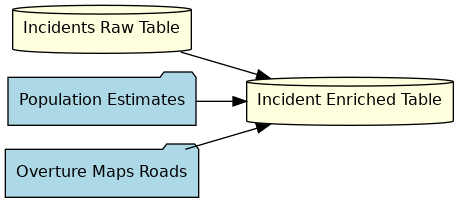

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incidents_enriched`
-- PARTITION BY DATE_TRUNC(DATE(start_time), MONTH)
CLUSTER BY hazard_type, iso_code AS
-- Countries reference (subset to valid country geoms)
WITH countries AS (
  SELECT
    d.id,
    d.country            AS iso_code,      -- ISO 3166-1 alpha-2
    d.names.primary      AS country_name,
    d.geometry           AS geom,          -- GEOGRAPHY
    SAFE_CAST(d.is_land AS BOOL)  AS is_land,
    SAFE_CAST(d.version AS INT64) AS version
  FROM `bigquery-public-data.overture_maps.division_area` d
  WHERE d.subtype = 'country'
    AND d.geometry IS NOT NULL
),

-- Attach country to each incident (prefer land polygons & latest version)
i_with_country AS (
  SELECT
    i.*,
    c.iso_code,
    c.country_name,
    ROW_NUMBER() OVER (
      PARTITION BY i.event_id
      ORDER BY c.is_land DESC, c.version DESC
    ) AS rn
  FROM `bqai_disaster.incidents_raw` AS i
  LEFT JOIN countries AS c
    ON SAFE.ST_WITHIN(i.geom, c.geom)     -- SAFE.* guards against rare invalid geoms
),
incidents AS (
  SELECT * EXCEPT(rn)
  FROM i_with_country
  WHERE rn = 1 OR rn IS NULL
),

# -- Incident-level roads (last 90d) already computed elsewhere
# roads_incident90 AS (
#   SELECT event_id, road_km
#   # FROM `bqai_disaster.incidents_roads_90d`
#   FROM `bqai_disaster.incidents_roads_10d`
# ),

-- Limit country fallback to countries that actually appear in these incidents
target_iso AS (
  SELECT DISTINCT iso_code
  FROM incidents
  WHERE iso_code IS NOT NULL
),

countries_needed AS (
  SELECT c.*
  FROM countries c
  JOIN target_iso t
    ON t.iso_code = c.iso_code
),

-- Heavy step (computed only for needed countries): total road length per country (km)
roads_by_country_fallback AS (
  SELECT
    c.iso_code,
    SUM(
      ST_LENGTH(
        -- SAFE.ST_INTERSECTION(r.geometry, c.geom)  -- SAFE.* to avoid geometry errors
        ST_INTERSECTION(r.geometry, c.geom)  -- SAFE.* to avoid geometry errors
      )
    ) / 1000.0 AS road_km
  FROM countries_needed c
  JOIN `bigquery-public-data.overture_maps.segment` r
    ON SAFE.ST_INTERSECTS(r.geometry, c.geom)
  GROUP BY c.iso_code
)

-- Final enrich
SELECT
  i.*,
  p.midyear_population AS population_estimate,
  -- COALESCE(ir.road_km, rb.road_km) AS road_km_country

  COALESCE( rb.road_km, 100) AS road_km_country --giving a default 100
FROM incidents AS i
LEFT JOIN `bqai_disaster.population_with_geom` AS p
  ON p.iso_code = i.iso_code
 AND p.year     = EXTRACT(YEAR FROM i.start_time)
-- LEFT JOIN roads_incident90 AS ir
--   ON ir.event_id = i.event_id
LEFT JOIN roads_by_country_fallback AS rb
  ON rb.iso_code = i.iso_code;


# -- ============================================

# **-- 7) Canonical text corpus for embeddings**

# -- ============================================

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_corpus` AS
WITH base AS (
  SELECT
    e.event_id,
    e.hazard_type,
    e.country_name,
    e.iso_code,
    e.severity,
    e.fatalities,
    e.injuries,
    e.damage_usd,
    e.source,
    e.start_time,
    e.population_estimate,
    e.road_km_country,
    aq.pm25_before,
    aq.pm25_after,
    aq.pm10_before,
    aq.pm10_after,
    nm.news_articles_48h,
    nm.news_tone_48h
  FROM `bqai_disaster.incidents_enriched` e
  -- LEFT JOIN `bqai_disaster.air_quality_metrics` aq USING (event_id)
  LEFT JOIN `bqai_disaster.openaq_locations_near_incidents` aq USING (event_id)
  LEFT JOIN `bqai_disaster.news_metrics_recent` nm USING (event_id)
)
SELECT
  event_id,
  CONCAT(
    'Type=', IFNULL(hazard_type, 'unknown'),
    '; Location=', IFNULL(country_name, 'unknown'),
    '; ISO=', IFNULL(iso_code, 'NA'),
    '; When=', IFNULL(FORMAT_TIMESTAMP('%Y-%m-%dT%H:%MZ', TIMESTAMP(start_time)), 'NA'),
    '; Severity=', IFNULL(CAST(severity AS STRING), 'NA'),
    '; Fatalities=', IFNULL(CAST(fatalities AS STRING), '0'),
    '; Injuries=', IFNULL(CAST(injuries AS STRING), '0'),
    '; DamageUSD=', IFNULL(CAST(damage_usd AS STRING), '0'),
    '; Pop=', IFNULL(CAST(CAST(population_estimate AS INT64) AS STRING), 'NA'),
    '; RoadsKM=', IFNULL(CAST(ROUND(road_km_country, 1) AS STRING), 'NA'),
    -- AQ deltas (only if we have data)
    '; PM25_before=', IFNULL(CAST(ROUND(pm25_before, 1) AS STRING), 'NA'),
    '; PM25_after=',  IFNULL(CAST(ROUND(pm25_after,  1) AS STRING), 'NA'),
    '; PM10_before=', IFNULL(CAST(ROUND(pm10_before, 1) AS STRING), 'NA'),
    '; PM10_after=',  IFNULL(CAST(ROUND(pm10_after,  1) AS STRING), 'NA'),
    -- News
    '; NewsArticles48h=', IFNULL(CAST(news_articles_48h AS STRING), '0'),
    '; NewsTone48h=',     IFNULL(CAST(ROUND(news_tone_48h, 3) AS STRING), 'NA'),
    '; Source=', IFNULL(source, 'NA')
  ) AS description
FROM base;


# -- ============================================

# **-- 8) Generate embeddings**

# -- ============================================

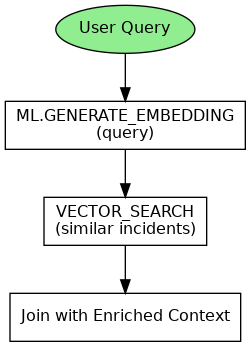

For ML.GENERATE_EMBEDDING to work, a remote connection needs to be set up.  


 **GENERATE CONNECTION - us.vertex-ai and give vertex-ai user permission for the corresponding service account**
   

Steps are explained here: https://medium.com/@chandrasekhar.aish/bigquery-connections-7ae1c777f91a

## **A) Create an embedding model**

In [ ]:
%%bigquery results
CREATE OR REPLACE MODEL `bqai_disaster.embedding_text`
REMOTE WITH CONNECTION `incidentsense.us.vertex_ai`
OPTIONS (
  endpoint = 'text-embedding-004'   -- or full URL; region must match the connection
);

## **B) Semantic Vector Creation**




In [ ]:
%%bigquery results
CREATE `bqai_disaster.incident_embeddings_arr` AS
# CREATE OR REPLACE TABLE `bqai_disaster.incident_embeddings_arr` AS
SELECT
  event_id,
  ml_generate_embedding_result AS emb
FROM ML.GENERATE_EMBEDDING(
  MODEL `bqai_disaster.embedding_text`,
  (
    SELECT event_id, description AS content
    FROM `bqai_disaster.incident_corpus`
  ),
  -- Optional: set task type and vector size
  STRUCT(TRUE AS flatten_json_output, 'RETRIEVAL_DOCUMENT' AS task_type, 768 AS output_dimensionality)
);

## **C) Denormalized table with metadata and embeddings creation**

In [ ]:
# -- Create a denormalized table that includes metadata + vectors
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_embeddings_wide` AS
SELECT
  i.event_id,
  i.hazard_type,
  DATE(i.start_time) AS event_date,
  i.country_name,
  e.emb          -- FLOAT64[] (REPEATED) from your current table
FROM `bqai_disaster.incidents_enriched` i
JOIN `bqai_disaster.incident_embeddings_arr` e
  USING (event_id);

# -- ============================================

# **-- 9) Create vector index for fast similarity**

# -- ============================================

In [ ]:
%%bigquery results
-- One-time (or re-run when table changes)
CREATE OR REPLACE VECTOR INDEX `bqai_disaster.incident_vecindex`
ON `bqai_disaster.incident_embeddings_wide` (emb)
STORING(event_id, hazard_type, event_date, country_name)
OPTIONS(
  index_type    = 'IVF',
  distance_type = 'COSINE',
  ivf_options   = '{"num_lists": 1000}'
);

# -- ============================================

# **-- 10) Find top-5 similar incidents**

# -- ============================================

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.similar_incidents_top5` AS
SELECT
  h.query.event_id AS query_event,
  h.base.event_id  AS neighbor_event,
  CAST(h.distance AS FLOAT64)       AS cosine_distance,
  1.0 - CAST(h.distance AS FLOAT64) AS cosine_similarity
FROM VECTOR_SEARCH(
  -- BASE with true prefiltering (needs columns present + in index STORING)
  (SELECT event_id, emb, hazard_type, event_date, country_name
   FROM `bqai_disaster.incident_embeddings_wide`
   WHERE event_date >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 YEAR)),
  'emb',
  -- QUERY set (batch recent incidents only)
  (SELECT event_id, emb
   FROM `bqai_disaster.incident_embeddings_wide`
   WHERE event_date >= DATE_SUB(CURRENT_DATE(), INTERVAL 6 MONTH)),
  'emb',
  top_k         => 6,
  distance_type => 'COSINE',
  options       => '{"fraction_lists_to_search": 0.02}'
) AS h
WHERE h.base.event_id != h.query.event_id
QUALIFY ROW_NUMBER() OVER (
  PARTITION BY h.query.event_id ORDER BY h.distance
) <= 5;

# -- ============================================

# **-- 11) Impact metrics (population × severity × news pulse)**

# -- ============================================

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_features_recent` AS
WITH base AS (
  SELECT
    i.event_id,
    i.hazard_type,
    i.start_time,
    i.country_name,
    i.severity,
    SAFE.LOG10(1 + COALESCE(i.population,0)) AS log_pop,
    COALESCE(n.news_articles_48h, 0) AS news_articles_48h,
    COALESCE(n.news_tone_48h, 0.0)   AS news_tone_48h
  FROM `bqai_disaster.incidents_enriched` i
  LEFT JOIN `bqai_disaster.news_metrics_recent` n USING(event_id)
),
by_hazard AS (
  SELECT
    hazard_type,
    AVG(severity) AS sev_mean,
    STDDEV_POP(severity) AS sev_std,
    AVG(log_pop) AS pop_mean,
    STDDEV_POP(log_pop) AS pop_std,
    AVG(news_articles_48h) AS news_mean,
    STDDEV_POP(news_articles_48h) AS news_std
  FROM base
  GROUP BY hazard_type
)
SELECT
  b.event_id, b.hazard_type, b.start_time, b.country_name,
  b.severity,
  b.log_pop,
  b.news_articles_48h, b.news_tone_48h,
  -- Z-scores with SAFE divide
  (b.severity - h.sev_mean) / NULLIF(h.sev_std,0)           AS z_severity,
  (b.log_pop - h.pop_mean) / NULLIF(h.pop_std,0)            AS z_log_pop,
  (b.news_articles_48h - h.news_mean) / NULLIF(h.news_std,0) AS z_news,
  -- Simple interpretable Impact Score (0–100-ish)
  LEAST(100,
    20 + 20*COALESCE((b.severity - h.sev_mean)/NULLIF(h.sev_std,0),0) +
         20*COALESCE((b.log_pop  - h.pop_mean)/NULLIF(h.pop_std,0),0) +
         10*COALESCE((b.news_articles_48h - h.news_mean)/NULLIF(h.news_std,0),0) +
          5*COALESCE(b.news_tone_48h/10.0, 0)      -- tone is roughly [-10,10]
  ) AS impact_score
FROM base b
JOIN by_hazard h USING(hazard_type);

# -- ============================================

# **-- 10) Generate brief summaries with BigQuery AI**
           --   “Why similar?” explanation + human brief (AI)

# -- ============================================

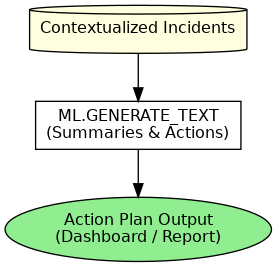


-- **(A) One-time: Create a remote LLM model**

In [ ]:
%%bigquery results
CREATE OR REPLACE MODEL `bqai_disaster.gemini_flash`
REMOTE WITH CONNECTION `incidentsense.us.vertex_ai`
OPTIONS (
  endpoint = 'gemini-2.0-flash'  -- any supported Gemini model is fine
);

**-- (B) Classify hazard buckets for every event, check what conditions changed and Create Incident Briefs using ML.GENERATE_TEXT**

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_briefs_ml_generate_text` AS
WITH
-- 1) Classify hazard buckets for every event (scalar AI.GENERATE)
tags AS (
  SELECT
    f.event_id,
    AI.GENERATE(
      prompt => CONCAT(
        'Classify into exactly one of [wind, flood, seismic, cyclone, winter, wildfire, other] ',
        'based on the short description that follows. Return ONLY the label. ',
        'Text: ',
        f.hazard_type, ' ',
        IFNULL(f.country_name, ''),
        ' sev=', CAST(f.severity AS STRING)
      ),
      connection_id => 'us.vertex-ai',
      endpoint      => 'gemini-2.0-flash'
    ).result AS hazard_bucket
  FROM `bqai_disaster.incident_features_recent` f
),

-- 2) Build all query–neighbor pairs with features
joined AS (
  SELECT
    s.query_event,
    s.neighbor_event,
    s.cosine_similarity,
    q.hazard_type           AS query_type,
    q.country_name          AS query_country,
    q.start_time            AS query_start,
    q.severity              AS query_severity,
    q.impact_score          AS query_impact,
    n.hazard_type           AS neigh_type,
    n.country_name          AS neigh_country,
    n.start_time            AS neigh_start,
    n.severity              AS neigh_severity,
    n.impact_score          AS neigh_impact
  FROM `bqai_disaster.similar_incidents_top5` s
  JOIN `bqai_disaster.incident_features_recent` q
    ON q.event_id = s.query_event
  JOIN `bqai_disaster.incident_features_recent` n
    ON n.event_id = s.neighbor_event
),

-- 3) Attach hazard buckets and compute deltas
enriched AS (
  SELECT
    j.*,
    tq.hazard_bucket AS query_bucket,
    tn.hazard_bucket AS neigh_bucket,
    (j.query_severity - j.neigh_severity)   AS delta_severity,
    (j.query_impact  - j.neigh_impact)      AS delta_impact
  FROM joined j
  LEFT JOIN tags tq ON tq.event_id = j.query_event
  LEFT JOIN tags tn ON tn.event_id = j.neighbor_event
)

-- 4) Call the remote LLM once per row with a rich prompt
SELECT
  query_event,
  neighbor_event,
  cosine_similarity,
  ml_generate_text_llm_result AS similarity_brief
FROM ML.GENERATE_TEXT(
  MODEL `bqai_disaster.gemini_flash`,
  (
    SELECT
      query_event,
      neighbor_event,
      cosine_similarity,
      CONCAT(
        'Write a concise (80–120 words) disaster similarity brief for an emergency manager.', '\n',
        'Query: type=', query_type,
          ', country=', IFNULL(query_country, 'Unknown'),
          ', start=', CAST(query_start AS STRING),
          ', severity=', CAST(query_severity AS STRING),
          ', impact_score=', CAST(query_impact AS STRING),
          ', bucket=', IFNULL(query_bucket, 'unknown'), '.', '\n',
        'Neighbor: type=', neigh_type,
          ', country=', IFNULL(neigh_country, 'Unknown'),
          ', start=', CAST(neigh_start AS STRING),
          ', severity=', CAST(neigh_severity AS STRING),
          ', impact_score=', CAST(neigh_impact AS STRING),
          ', bucket=', IFNULL(neigh_bucket, 'unknown'), '.', '\n',
        'Cosine similarity=', CAST(cosine_similarity AS STRING), '.', '\n',
        'Deltas (query - neighbor): severity=', CAST(delta_severity AS STRING),
          ', impact_score=', CAST(delta_impact AS STRING), '.', '\n',
        'Explain WHY they are similar (hazard type, region, population exposure, recency). ',
        'Then provide 3 actionable bullet points for the QUERY incident. ',
        'Keep actions concrete, short, and non-duplicative.'
      ) AS prompt
    FROM enriched
  ),
  STRUCT(
    512  AS max_output_tokens,
    0.2  AS temperature,
    TRUE AS flatten_json_output
  )
)

**-- (C) Another way: Create Incident Briefs using AI.GENERATE**

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_briefs_ai_generate` AS
WITH
-- 1) Classify hazard buckets for every event
tags AS (
  SELECT
    f.event_id,
    AI.GENERATE(
      prompt => CONCAT(
        'Classify into exactly one of [wind, flood, seismic, cyclone, winter, wildfire, other] ',
        'based on the short description that follows. Return ONLY the label. ',
        'Text: ',
        f.hazard_type, ' ',
        IFNULL(f.country_name, ''),
        ' sev=', CAST(f.severity AS STRING)
      ),
      connection_id => 'us.vertex-ai',
      endpoint      => 'gemini-2.0-flash'
    ).result AS hazard_bucket
  FROM `bqai_disaster.incident_features_recent` f
),

-- 2) Build all query–neighbor pairs with features
joined AS (
  SELECT
    s.query_event,
    s.neighbor_event,
    s.cosine_similarity,
    q.hazard_type  AS query_type,
    q.country_name AS query_country,
    q.start_time   AS query_start,
    q.severity     AS query_severity,
    q.impact_score AS query_impact,
    n.hazard_type  AS neigh_type,
    n.country_name AS neigh_country,
    n.start_time   AS neigh_start,
    n.severity     AS neigh_severity,
    n.impact_score AS neigh_impact
  FROM `bqai_disaster.similar_incidents_top5` s
  JOIN `bqai_disaster.incident_features_recent` q ON q.event_id = s.query_event
  JOIN `bqai_disaster.incident_features_recent` n ON n.event_id = s.neighbor_event
),

-- 3) Attach hazard buckets and compute deltas
enriched AS (
  SELECT
    j.*,
    tq.hazard_bucket AS query_bucket,
    tn.hazard_bucket AS neigh_bucket,
    (j.query_severity - j.neigh_severity) AS delta_severity,
    (j.query_impact  - j.neigh_impact)    AS delta_impact
  FROM joined j
  LEFT JOIN tags tq ON tq.event_id = j.query_event
  LEFT JOIN tags tn ON tn.event_id = j.neighbor_event
)

-- 4) Generate similarity brief with richer context
SELECT
  query_event,
  neighbor_event,
  cosine_similarity,
  AI.GENERATE(
    prompt => CONCAT(
      'Write a concise (80–120 words) disaster similarity brief for an emergency manager.', '\n',
      'Query: type=', query_type,
        ', country=', IFNULL(query_country, 'Unknown'),
        ', start=', CAST(query_start AS STRING),
        ', severity=', CAST(query_severity AS STRING),
        ', impact_score=', CAST(query_impact AS STRING),
        ', bucket=', IFNULL(query_bucket, 'unknown'), '.', '\n',
      'Neighbor: type=', neigh_type,
        ', country=', IFNULL(neigh_country, 'Unknown'),
        ', start=', CAST(neigh_start AS STRING),
        ', severity=', CAST(neigh_severity AS STRING),
        ', impact_score=', CAST(neigh_impact AS STRING),
        ', bucket=', IFNULL(neigh_bucket, 'unknown'), '.', '\n',
      'Cosine similarity=', CAST(cosine_similarity AS STRING), '.', '\n',
      'Deltas (query - neighbor): severity=', CAST(delta_severity AS STRING),
        ', impact_score=', CAST(delta_impact AS STRING), '.', '\n',
      'Explain WHY they are similar (hazard type, region, population exposure, recency). ',
      'Then provide 3 actionable bullet points for the QUERY incident. ',
      'Keep actions concrete, short, and non-duplicative.'
    ),
    connection_id => 'us.vertex-ai',
    endpoint      => 'gemini-2.0-flash'
  ).result AS similarity_brief
FROM enriched;



# -- ============================================

# **-- 11) AI-generated Action Plan table (structured)**

# -- ============================================

In [ ]:
%%bigquery results
CREATE OR REPLACE TABLE `bqai_disaster.incident_actions` AS
WITH ctx AS (
  SELECT
    b.query_event,
    STRING_AGG(
      CONCAT(n.neighbor_event, ' (sim=', FORMAT('%0.2f', n.cosine_similarity), ')'),
      ', '
      ORDER BY n.cosine_similarity DESC
    ) AS neighbor_list
  FROM `bqai_disaster.incident_briefs_ml_generate_text` b
  JOIN `bqai_disaster.similar_incidents_top5` n USING (query_event, neighbor_event)
  GROUP BY b.query_event
),
gen AS (
  SELECT
    query_event,
    -- Ask LLM to return only a JSON array of 5 objects
    ml_generate_text_llm_result AS json_actions
  FROM ML.GENERATE_TEXT(
    MODEL `bqai_disaster.gemini_flash`,
    (
      SELECT
        query_event,
        CONCAT(
          'You are assisting an emergency operations chief. ',
          'Return ONLY a JSON array with EXACTLY 5 objects. ',
          'Each object must have keys: "priority" (integer 1-5, where 1=highest), ',
          '"action" (string, <=90 chars), ',
          '"owner" (one of: "Ops","Logistics","Planning","Comms","Safety"), ',
          '"eta_hours" (integer). ',
          'No markdown, no extra prose, no code fences.', '\n',
          'Context: Query incident id=', query_event, '. ',
          'Top neighbors: ', neighbor_list, '. ',
          'Create concrete, short, non-duplicative actions tied to incident ops.'
        ) AS prompt
      FROM ctx
    ),
    STRUCT(
      256 AS max_output_tokens,
      0.2 AS temperature,
      TRUE AS flatten_json_output
    )
  )
)
SELECT
  query_event,
  SAFE_CAST(JSON_VALUE(item, '$.priority') AS INT64)   AS priority,
  JSON_VALUE(item, '$.action')                          AS action,
  JSON_VALUE(item, '$.owner')                           AS owner,
  SAFE_CAST(JSON_VALUE(item, '$.eta_hours') AS INT64)   AS eta_hours
FROM gen,
UNNEST(JSON_QUERY_ARRAY(json_actions)) AS item
ORDER BY query_event, priority;


## **Conclusion**


The whole pipeline was built using SQLs. The Python scripts where used in cases where data was not updated in public datasets. The embeddings can also be built from image/ documents data in GCS. Over this workflow, a full pipeline was built for **incident intelligence in BigQuery**: raw disaster events were enriched with country, population, road infrastructure, air quality, and news context; converted into **text descriptions and embeddings**; indexed for fast **semantic similarity search**; and combined with Gemini Flash to generate **similarity briefs and structured action plans** for emergency managers. This bridges structured data, vector search, and generative reasoning directly in SQL. **Next steps** include extending the system toward **forecasting and proactive alerts**. For example, using historical incident features (severity, population exposure, news velocity) as training data for time-series or classification models to **predict impact scores ahead of time**; building early-warning simulations that combine climate forecasts with semantic similarity of past disasters; and generating **forward-looking action playbooks** (e.g., “If a cyclone of this magnitude approaches Country X, expected impacts are …”). This moves the pipeline from retrospective analysis into **predictive decision support**.

